# **VGG19 Transfer Learning for 4-Class Image Classification**

In [1]:
# Install required packages
!pip install torch torchvision matplotlib seaborn scikit-learn pillow

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms, models
import torch.nn.functional as F

# Additional imports
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import glob
from collections import Counter
import random


In [2]:

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [3]:

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# DATA PREPARATION AND LOADING

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def prepare_data(data_path):
    """
    Prepare data from the organized folder structure
    Expected structure:
    data_path/
    ├── Cloudy/
    ├── Desert/
    ├── Green Area/
    └── Water/
    """
    class_names = ['Cloudy', 'Desert', 'Green Area', 'Water']
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    image_paths = []
    labels = []

    for class_name in class_names:
        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            # Get all image files
            extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
            class_images = []
            for ext in extensions:
                class_images.extend(glob.glob(os.path.join(class_path, ext)))
                class_images.extend(glob.glob(os.path.join(class_path, ext.upper())))

            image_paths.extend(class_images)
            labels.extend([class_to_idx[class_name]] * len(class_images))

    return image_paths, labels, class_names, class_to_idx

# Data Augmentation Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# VGG19 MODEL WITH TRANSFER LEARNING

In [5]:


class VGG19TransferLearning(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG19TransferLearning, self).__init__()

        # Load pretrained VGG19
        self.vgg19 = models.vgg19(pretrained=True)

        # Freeze all parameters initially
        for param in self.vgg19.parameters():
            param.requires_grad = False

        # Unfreeze the last few convolutional layers for fine-tuning
        # This allows the model to adapt to our specific dataset
        for param in self.vgg19.features[-8:].parameters():
            param.requires_grad = True

        # Replace the classifier with our custom one
        self.vgg19.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(2048, 512),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        # Initialize the new classifier layers
        for module in self.vgg19.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        return self.vgg19(x)


#  TRAINING AND EVALUATION FUNCTIONS

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=10, device='cuda'):
    """
    Train the VGG19 model with comprehensive monitoring
    """
    model.to(device)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

            # Print progress
            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100.0 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        # Calculate validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100.0 * val_correct / val_total

        # Update learning rate
        scheduler.step(avg_val_loss)

        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = model.state_dict().copy()

        # Store history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        # Print epoch results
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

    # Load best model
    model.load_state_dict(best_model_state)
    print(f'\nBest Validation Accuracy: {best_val_acc:.2f}%')

    return history

def evaluate_model(model, test_loader, device='cuda'):
    """
    Comprehensive evaluation of the model
    """
    model.eval()
    model.to(device)

    all_predictions = []
    all_targets = []
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = accuracy_score(all_targets, all_predictions)

    return all_predictions, all_targets, avg_test_loss, test_accuracy


# VISUALIZATION AND METRICS FUNCTIONS


In [7]:
def plot_training_curves(history):
    """
    Plot comprehensive training and validation curves with enhanced styling
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss curves with gradient fill
    ax1.plot(epochs, history['train_loss'], 'o-', color='#2E86AB',
             label='Training Loss', linewidth=3, markersize=6)
    ax1.plot(epochs, history['val_loss'], 's-', color='#A23B72',
             label='Validation Loss', linewidth=3, markersize=6)
    ax1.fill_between(epochs, history['train_loss'], alpha=0.3, color='#2E86AB')
    ax1.fill_between(epochs, history['val_loss'], alpha=0.3, color='#A23B72')
    ax1.set_title('Loss Progression', fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss Value', fontsize=12)
    ax1.legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, alpha=0.3)

    # Accuracy curves with gradient fill
    ax2.plot(epochs, history['train_acc'], 'o-', color='#F18F01',
             label='Training Accuracy', linewidth=3, markersize=6)
    ax2.plot(epochs, history['val_acc'], 's-', color='#C73E1D',
             label='Validation Accuracy', linewidth=3, markersize=6)
    ax2.fill_between(epochs, history['train_acc'], alpha=0.3, color='#F18F01')
    ax2.fill_between(epochs, history['val_acc'], alpha=0.3, color='#C73E1D')
    ax2.set_title('Accuracy Progression', fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
    ax2.grid(True, alpha=0.3)

    # Training vs Validation Gap (Loss)
    loss_gap = [abs(t - v) for t, v in zip(history['train_loss'], history['val_loss'])]
    ax3.bar(epochs, loss_gap, color='#FF6B6B', alpha=0.7, width=0.6)
    ax3.set_title('Training-Validation Loss Gap', fontsize=16, fontweight='bold', pad=20)
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Loss Difference', fontsize=12)
    ax3.grid(True, alpha=0.3)

    # Training vs Validation Gap (Accuracy)
    acc_gap = [abs(t - v) for t, v in zip(history['train_acc'], history['val_acc'])]
    ax4.bar(epochs, acc_gap, color='#4ECDC4', alpha=0.7, width=0.6)
    ax4.set_title('Training-Validation Accuracy Gap', fontsize=16, fontweight='bold', pad=20)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Accuracy Difference (%)', fontsize=12)
    ax4.grid(True, alpha=0.3)

    plt.suptitle('VGG19 Transfer Learning - Training Analysis',
                 fontsize=20, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot enhanced confusion matrix with multiple visualizations
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    cm = confusion_matrix(y_true, y_pred)

    # Create subplots for different visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Classic confusion matrix with counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Samples'}, ax=ax1)
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.set_ylabel('True Label', fontsize=12)

    # 2. Normalized confusion matrix (percentages)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage'}, ax=ax2)
    ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted Label', fontsize=12)
    ax2.set_ylabel('True Label', fontsize=12)

    # 3. Per-class accuracy visualization
    class_accuracies = []
    for i in range(len(class_names)):
        acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        class_accuracies.append(acc * 100)

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    bars = ax3.bar(class_names, class_accuracies, color=colors, alpha=0.8)
    ax3.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Accuracy (%)', fontsize=12)
    ax3.set_ylim(0, 100)

    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracies):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

    ax3.grid(True, alpha=0.3, axis='y')
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

    # 4. Class distribution in predictions vs actual
    actual_counts = [cm[i, :].sum() for i in range(len(class_names))]
    predicted_counts = [cm[:, i].sum() for i in range(len(class_names))]

    x = np.arange(len(class_names))
    width = 0.35

    bars1 = ax4.bar(x - width/2, actual_counts, width, label='Actual',
                    color='#2E86AB', alpha=0.8)
    bars2 = ax4.bar(x + width/2, predicted_counts, width, label='Predicted',
                    color='#A23B72', alpha=0.8)

    ax4.set_title('Class Distribution: Actual vs Predicted', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Number of Samples', fontsize=12)
    ax4.set_xticks(x)
    ax4.set_xticklabels(class_names)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

    for bar in bars2:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

    plt.suptitle('VGG19 Transfer Learning - Confusion Matrix Analysis',
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

def calculate_comprehensive_metrics(y_true, y_pred, class_names):
    """
    Calculate comprehensive metrics including precision, recall, specificity, and F1-score
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate precision, recall, F1-score using sklearn
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(class_names))
    )

    # Calculate specificity manually
    specificity = []
    for i in range(len(class_names)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)

    # Create comprehensive metrics dictionary
    metrics = {}
    for i, class_name in enumerate(class_names):
        metrics[class_name] = {
            'precision': precision[i],
            'recall': recall[i],  # Sensitivity
            'specificity': specificity[i],
            'f1_score': f1[i],
            'support': support[i]
        }

    # Calculate macro averages
    metrics['macro_avg'] = {
        'precision': np.mean(precision),
        'recall': np.mean(recall),
        'specificity': np.mean(specificity),
        'f1_score': np.mean(f1)
    }

    return metrics

def plot_comprehensive_metrics(metrics, class_names):
    """
    Create comprehensive metrics visualization dashboard
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    fig = plt.figure(figsize=(20, 12))

    # Create a complex grid layout
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

    # 1. Metrics Heatmap
    ax1 = fig.add_subplot(gs[0, :2])
    metrics_data = []
    metric_names = ['Precision', 'Sensitivity', 'Specificity', 'F1-Score']

    for class_name in class_names:
        class_metrics = metrics[class_name]
        metrics_data.append([
            class_metrics['precision'],
            class_metrics['recall'],
            class_metrics['specificity'],
            class_metrics['f1_score']
        ])

    metrics_array = np.array(metrics_data)
    sns.heatmap(metrics_array, annot=True, fmt='.3f', cmap='RdYlGn',
                xticklabels=metric_names, yticklabels=class_names,
                cbar_kws={'label': 'Score'}, ax=ax1)
    ax1.set_title('Performance Metrics Heatmap', fontsize=16, fontweight='bold')

    # 2. Radar Chart for Overall Performance
    ax2 = fig.add_subplot(gs[0, 2:], projection='polar')
    angles = np.linspace(0, 2 * np.pi, len(metric_names), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    for i, class_name in enumerate(class_names):
        values = [
            metrics[class_name]['precision'],
            metrics[class_name]['recall'],
            metrics[class_name]['specificity'],
            metrics[class_name]['f1_score']
        ]
        values += values[:1]  # Complete the circle

        ax2.plot(angles, values, 'o-', linewidth=2, label=class_name,
                color=colors[i], markersize=6)
        ax2.fill(angles, values, alpha=0.25, color=colors[i])

    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(metric_names, fontsize=11)
    ax2.set_ylim(0, 1)
    ax2.set_title('Performance Radar Chart', fontsize=16, fontweight='bold', pad=30)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax2.grid(True)

    # 3. Precision Comparison
    ax3 = fig.add_subplot(gs[1, 0])
    precisions = [metrics[class_name]['precision'] for class_name in class_names]
    bars = ax3.bar(class_names, precisions, color='#FF6B6B', alpha=0.8)
    ax3.set_title('Precision by Class', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Precision', fontsize=12)
    ax3.set_ylim(0, 1)
    ax3.grid(True, alpha=0.3, axis='y')

    for bar, prec in zip(bars, precisions):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{prec:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

    # 4. Sensitivity (Recall) Comparison
    ax4 = fig.add_subplot(gs[1, 1])
    recalls = [metrics[class_name]['recall'] for class_name in class_names]
    bars = ax4.bar(class_names, recalls, color='#4ECDC4', alpha=0.8)
    ax4.set_title('Sensitivity (Recall) by Class', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Sensitivity', fontsize=12)
    ax4.set_ylim(0, 1)
    ax4.grid(True, alpha=0.3, axis='y')

    for bar, rec in zip(bars, recalls):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{rec:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

    # 5. Specificity Comparison
    ax5 = fig.add_subplot(gs[1, 2])
    specificities = [metrics[class_name]['specificity'] for class_name in class_names]
    bars = ax5.bar(class_names, specificities, color='#45B7D1', alpha=0.8)
    ax5.set_title('Specificity by Class', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Specificity', fontsize=12)
    ax5.set_ylim(0, 1)
    ax5.grid(True, alpha=0.3, axis='y')

    for bar, spec in zip(bars, specificities):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{spec:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')

    # 6. F1-Score Comparison
    ax6 = fig.add_subplot(gs[1, 3])
    f1_scores = [metrics[class_name]['f1_score'] for class_name in class_names]
    bars = ax6.bar(class_names, f1_scores, color='#96CEB4', alpha=0.8)
    ax6.set_title('F1-Score by Class', fontsize=14, fontweight='bold')
    ax6.set_ylabel('F1-Score', fontsize=12)
    ax6.set_ylim(0, 1)
    ax6.grid(True, alpha=0.3, axis='y')

    for bar, f1 in zip(bars, f1_scores):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.setp(ax6.get_xticklabels(), rotation=45, ha='right')

    # 7. Overall Performance Summary
    ax7 = fig.add_subplot(gs[2, :])
    macro_metrics = metrics['macro_avg']
    summary_data = {
        'Macro Avg Precision': macro_metrics['precision'],
        'Macro Avg Recall': macro_metrics['recall'],
        'Macro Avg Specificity': macro_metrics['specificity'],
        'Macro Avg F1-Score': macro_metrics['f1_score']
    }

    # Create horizontal bar chart for summary
    y_pos = np.arange(len(summary_data))
    values = list(summary_data.values())
    colors_summary = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    bars = ax7.barh(y_pos, values, color=colors_summary, alpha=0.8)
    ax7.set_yticks(y_pos)
    ax7.set_yticklabels(list(summary_data.keys()), fontsize=12)
    ax7.set_xlabel('Score', fontsize=12)
    ax7.set_title('Macro Average Performance Summary', fontsize=16, fontweight='bold')
    ax7.set_xlim(0, 1)
    ax7.grid(True, alpha=0.3, axis='x')

    # Add value labels on bars
    for bar, value in zip(bars, values):
        width = bar.get_width()
        ax7.text(width + 0.02, bar.get_y() + bar.get_height()/2.,
                f'{value:.3f}', ha='left', va='center', fontweight='bold')

    plt.suptitle('VGG19 Transfer Learning - Comprehensive Performance Analysis',
                 fontsize=22, fontweight='bold', y=0.98)
    plt.show()

def create_performance_summary_card(test_accuracy, test_loss, metrics, total_images, class_names):
    """
    Create a beautiful performance summary card
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')

    # Create background
    rect = plt.Rectangle((0.05, 0.05), 0.9, 0.9, linewidth=2,
                        edgecolor='#2E86AB', facecolor='#F8F9FA', alpha=0.3)
    ax.add_patch(rect)

    # Title
    ax.text(0.5, 0.9, 'VGG19 Transfer Learning Performance Summary',
            fontsize=24, fontweight='bold', ha='center', va='center',
            color='#2E86AB')

    # Main metrics
    ax.text(0.5, 0.8, f'Overall Test Accuracy: {test_accuracy*100:.2f}%',
            fontsize=20, fontweight='bold', ha='center', va='center',
            color='#C73E1D')

    ax.text(0.5, 0.75, f'Test Loss: {test_loss:.4f}',
            fontsize=16, ha='center', va='center', color='#333333')

    # Dataset info
    ax.text(0.5, 0.65, f'Dataset: {total_images} images across {len(class_names)} classes',
            fontsize=14, ha='center', va='center', color='#666666')

    # Macro averages in a nice format
    macro_avg = metrics['macro_avg']
    metrics_text = f"""
    Macro Average Metrics:

    🎯 Precision: {macro_avg['precision']:.3f}
    🔍 Sensitivity (Recall): {macro_avg['recall']:.3f}
    🛡️ Specificity: {macro_avg['specificity']:.3f}
    ⚖️ F1-Score: {macro_avg['f1_score']:.3f}
    """

    ax.text(0.5, 0.45, metrics_text, fontsize=14, ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
            color='#333333')

    # Performance grade
    avg_score = (macro_avg['precision'] + macro_avg['recall'] +
                macro_avg['specificity'] + macro_avg['f1_score']) / 4

    if avg_score >= 0.9:
        grade = "A+ Excellent"
        grade_color = "#2ECC71"
    elif avg_score >= 0.8:
        grade = "A Good"
        grade_color = "#3498DB"
    elif avg_score >= 0.7:
        grade = "B Fair"
        grade_color = "#F39C12"
    else:
        grade = "C Needs Improvement"
        grade_color = "#E74C3C"

    ax.text(0.5, 0.2, f'Performance Grade: {grade}',
            fontsize=18, fontweight='bold', ha='center', va='center',
            color=grade_color,
            bbox=dict(boxstyle="round,pad=0.5", facecolor=grade_color, alpha=0.2))

    # Timestamp
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    ax.text(0.95, 0.05, f'Generated: {timestamp}',
            fontsize=10, ha='right', va='bottom', color='#999999')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def check_class_imbalance(labels, class_names):
    """
    Check for class imbalance and suggest oversampling if needed
    """
    label_counts = Counter(labels)
    total_samples = len(labels)

    print("Class Distribution Analysis:")
    print("-" * 40)

    imbalance_detected = False
    min_count = min(label_counts.values())
    max_count = max(label_counts.values())

    for i, class_name in enumerate(class_names):
        count = label_counts[i]
        percentage = (count / total_samples) * 100
        print(f"{class_name}: {count} samples ({percentage:.1f}%)")

    # Check if imbalance ratio is significant (>2:1)
    if max_count / min_count > 2:
        imbalance_detected = True
        print(f"\n⚠️  Class imbalance detected! Ratio: {max_count/min_count:.1f}:1")
        print("Consider using weighted loss function or oversampling techniques.")
    else:
        print("\n✅ Classes are relatively balanced.")

    return imbalance_detected, label_counts

def create_weighted_sampler(labels):
    """
    Create a weighted sampler for handling class imbalance
    """
    label_counts = Counter(labels)
    num_samples = len(labels)

    # Calculate weights for each class
    weights = []
    for label in labels:
        class_count = label_counts[label]
        weight = num_samples / (len(label_counts) * class_count)
        weights.append(weight)

    return WeightedRandomSampler(weights, num_samples, replacement=True)


# MAIN EXECUTION FUNCTION

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
VGG19 TRANSFER LEARNING FOR 4-CLASS IMAGE CLASSIFICATION

1. Loading and preparing data...
Dataset loaded successfully!
Total images: 1752
Number of classes: 4
Classes: ['Cloudy', 'Desert', 'Green Area', 'Water']

2. Analyzing class distribution...
Class Distribution Analysis:
----------------------------------------
Cloudy: 476 samples (27.2%)
Desert: 489 samples (27.9%)
Green Area: 490 samples (28.0%)
Water: 297 samples (17.0%)

✅ Classes are relatively balanced.

3. Splitting data into train/validation/test sets...
Training set: 1226 images (70.0%)
Validation set: 263 images (15.0%)
Test set: 263 images (15.0%)

4. Creating datasets and data loaders...

5. Initializing VGG19 model with transfer learning...
Total parameters: 139,586,628
Trainable parameters: 119,562,244
Frozen parameters: 20,024,384

6. Configuring training setup...
Using standard CrossEntr

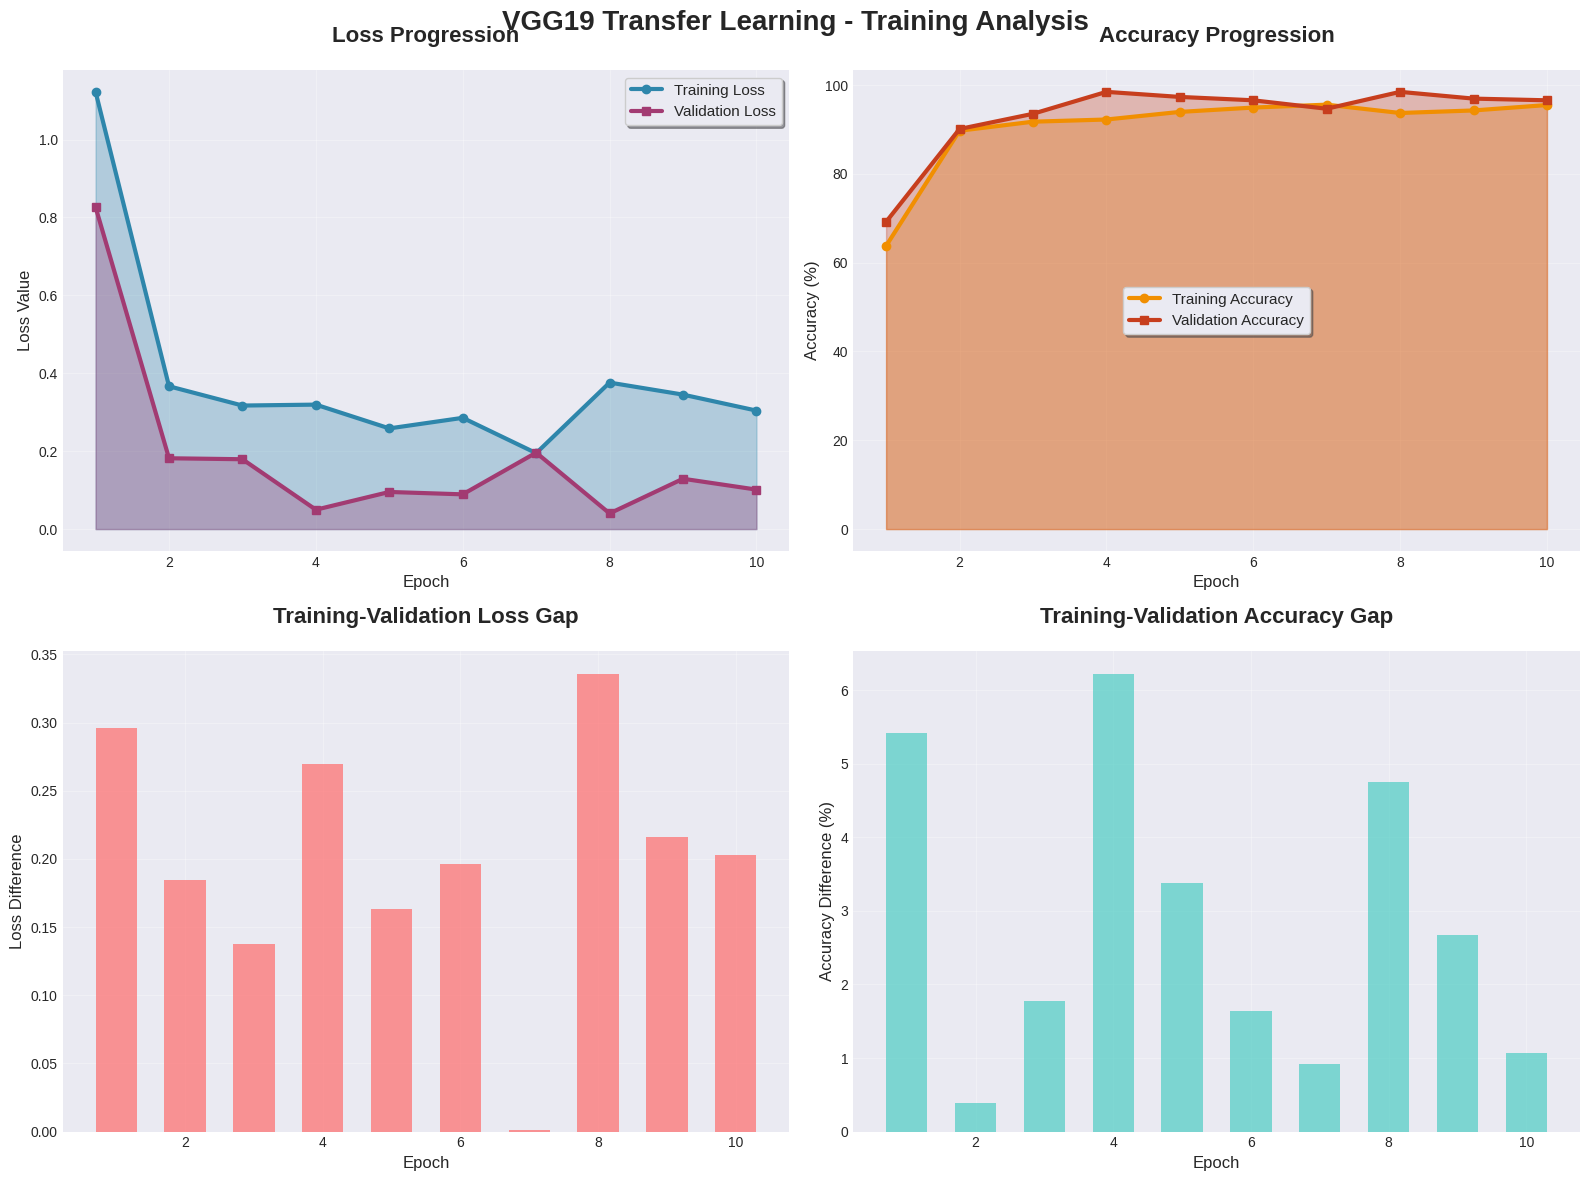

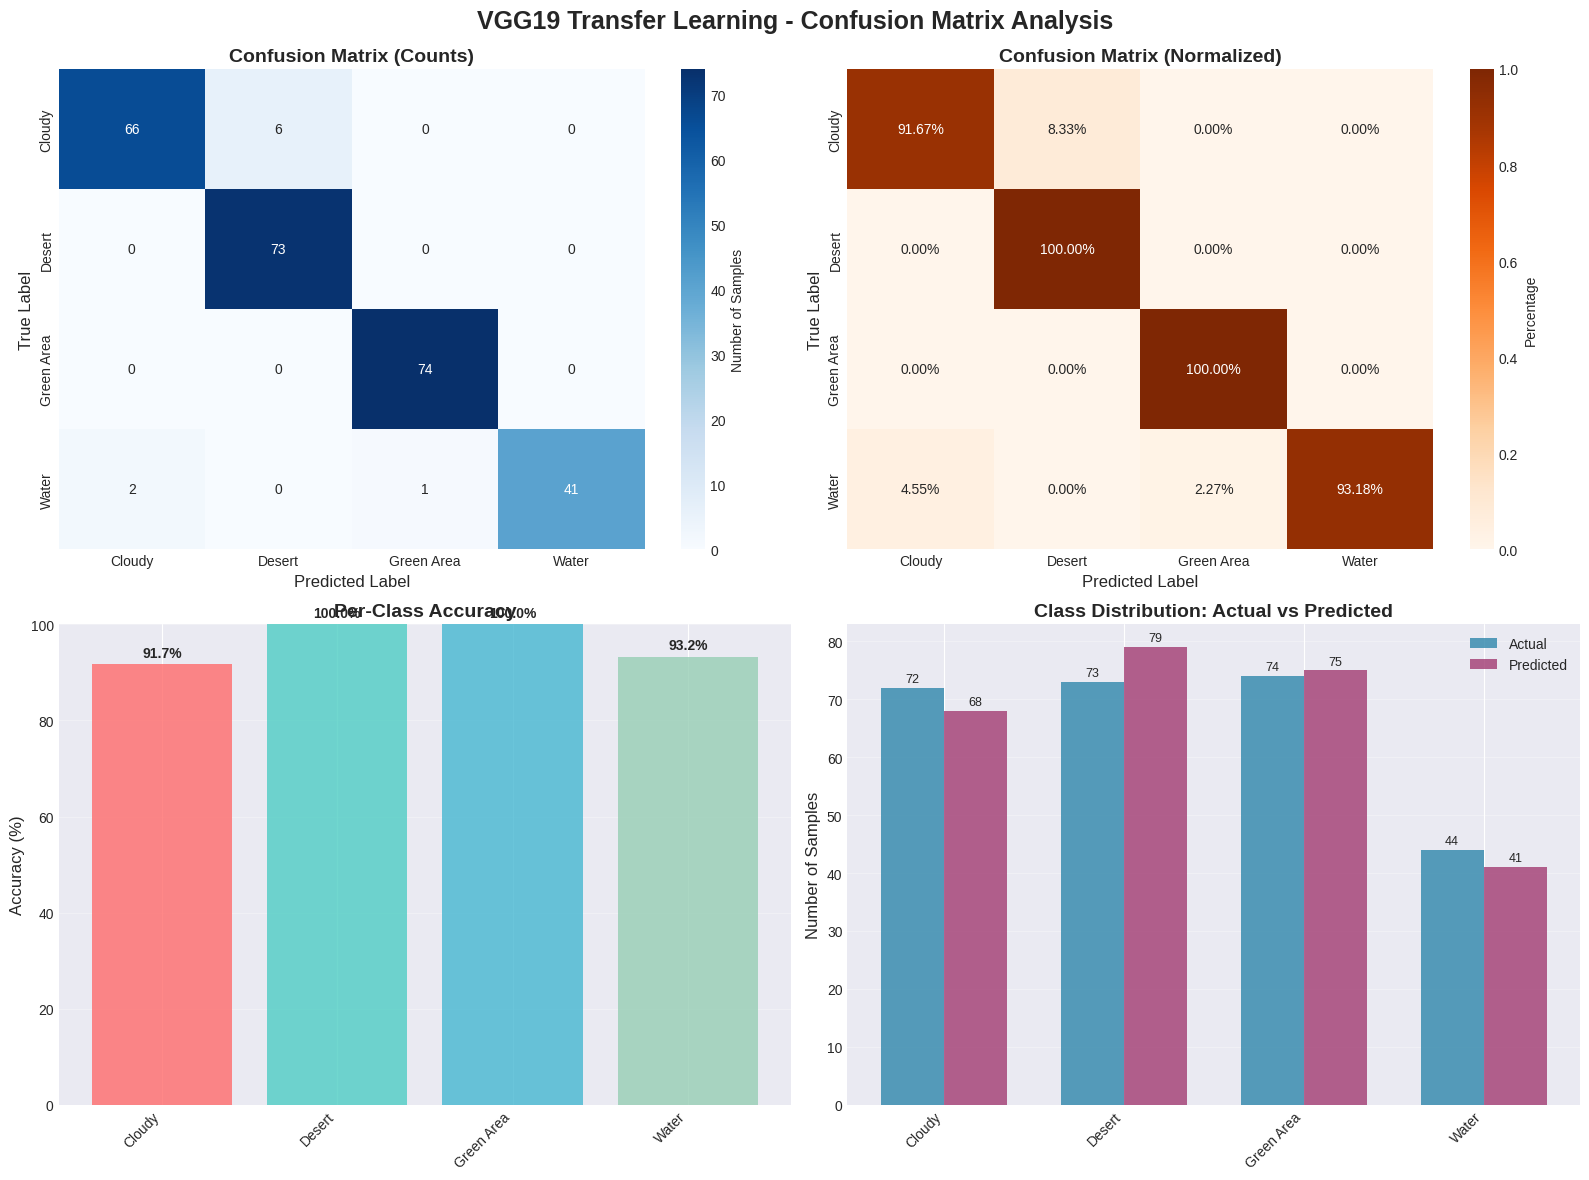

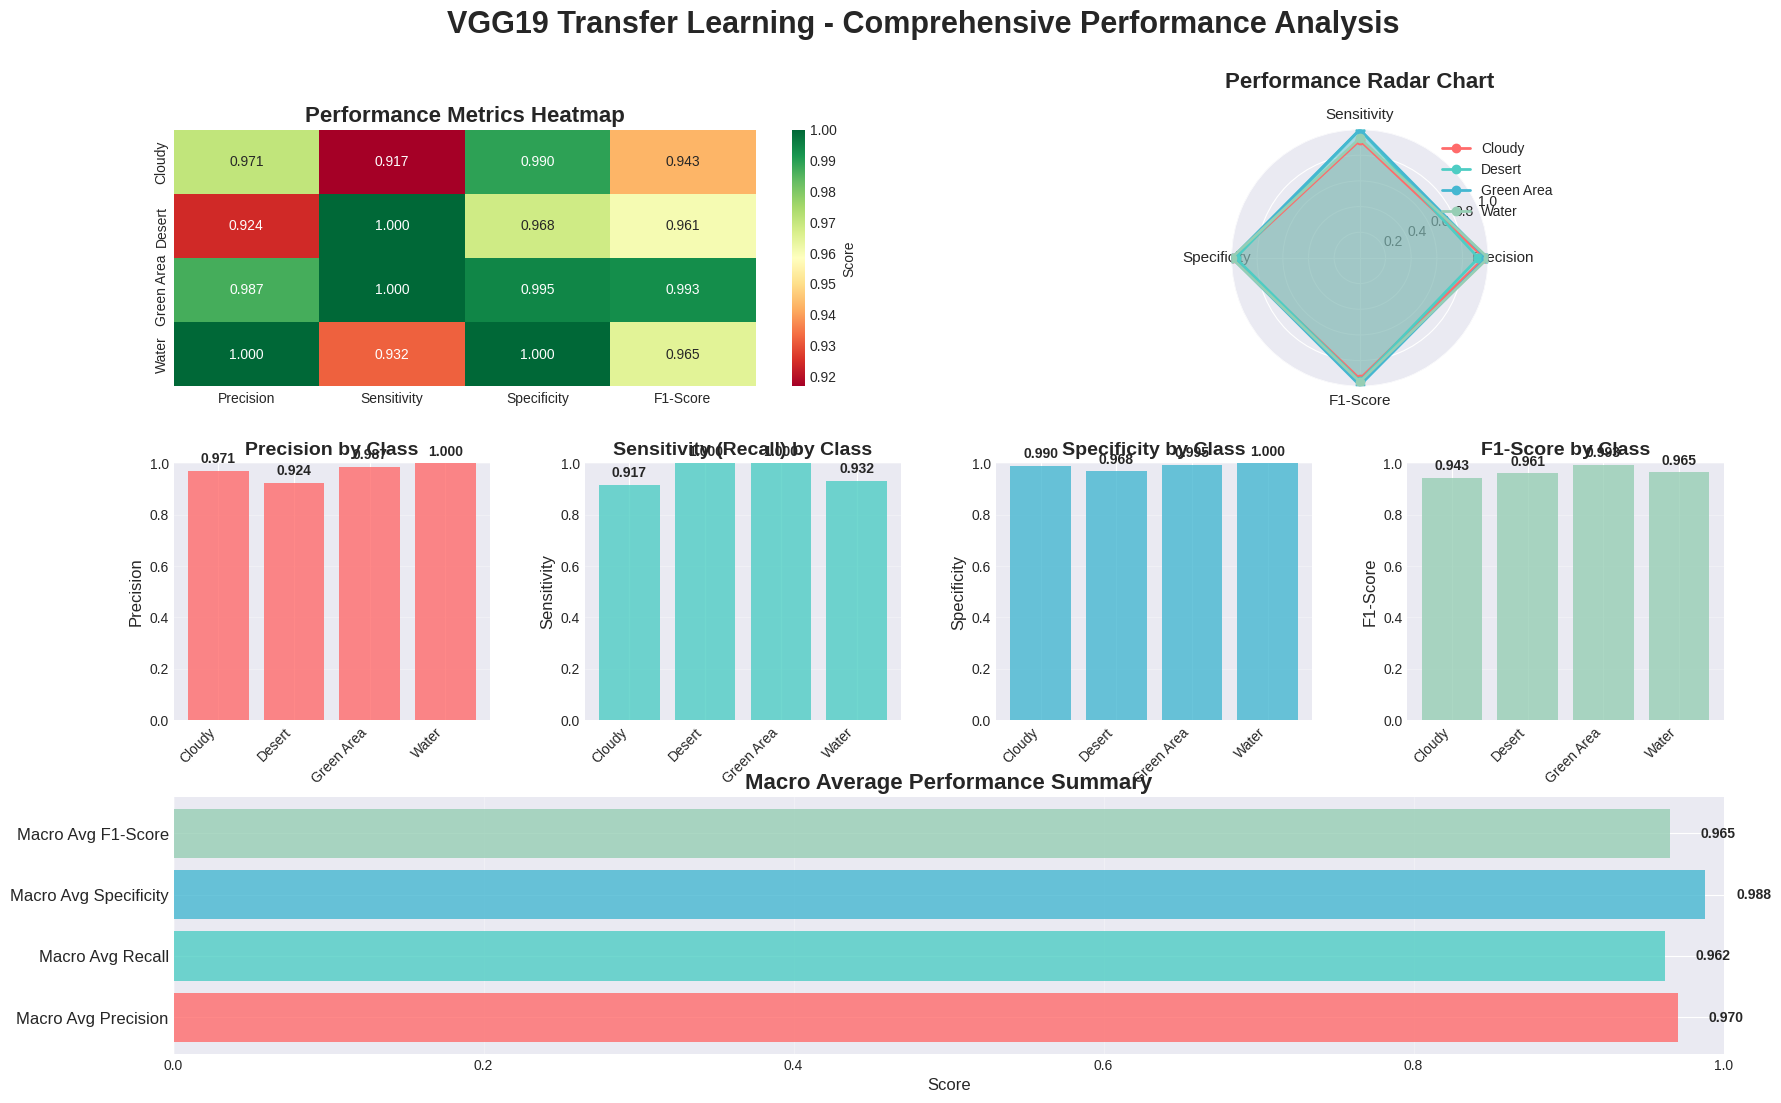

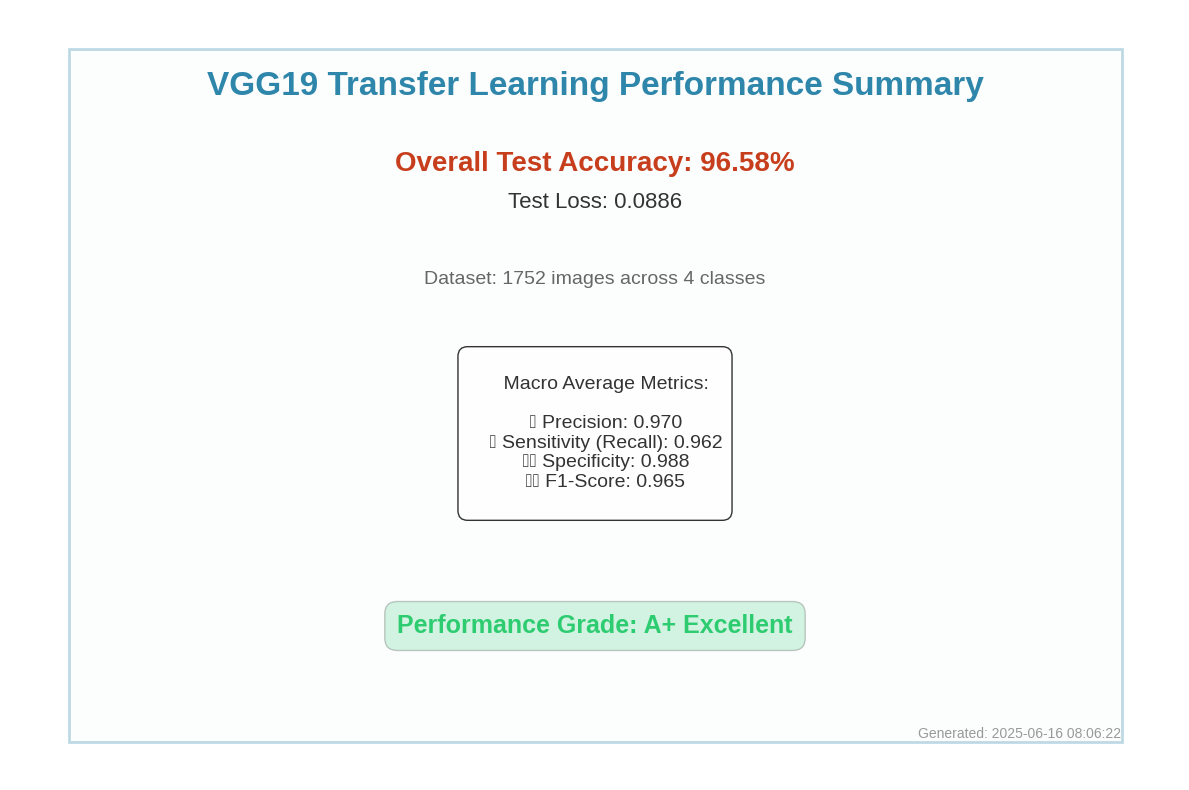


Pipeline execution completed.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from PIL import Image
import os

# Add necessary imports if not already present

# Assuming prepare_data and ImageDataset are defined elsewhere in the notebook
# If not, you'll need to define them here or in a previous cell


def main():
    """
    Main function to execute the complete VGG19 transfer learning pipeline
    """
    # Data path configuration
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/MyDrive/Dataset"

    print("=" * 60)
    print("VGG19 TRANSFER LEARNING FOR 4-CLASS IMAGE CLASSIFICATION")
    print("=" * 60)


    # Step 1: Load and prepare data
    print("\n1. Loading and preparing data...")
    image_paths, labels, class_names, class_to_idx = prepare_data(DATA_PATH)

    print(f"Dataset loaded successfully!")
    print(f"Total images: {len(image_paths)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Classes: {class_names}")

    # Step 2: Analyze class distribution
    print("\n2. Analyzing class distribution...")
    imbalance_detected, label_counts = check_class_imbalance(labels, class_names)

    # Step 3: Data splitting (70% train, 15% validation, 15% test)
    print("\n3. Splitting data into train/validation/test sets...")
    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, labels, test_size=0.3, random_state=42, stratify=labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"Training set: {len(X_train)} images ({len(X_train)/len(image_paths)*100:.1f}%)")
    print(f"Validation set: {len(X_val)} images ({len(X_val)/len(image_paths)*100:.1f}%)")
    print(f"Test set: {len(X_test)} images ({len(X_test)/len(image_paths)*100:.1f}%)")

    # Step 4: Create datasets and data loaders
    print("\n4. Creating datasets and data loaders...")

    # Define transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    train_dataset = ImageDataset(X_train, y_train, train_transform)
    val_dataset = ImageDataset(X_val, y_val, val_test_transform)
    test_dataset = ImageDataset(X_test, y_test, val_test_transform)

    batch_size = 32

    # Create sampler for handling class imbalance if detected
    if imbalance_detected:
        print("Using weighted sampling to handle class imbalance...")
        sampler = create_weighted_sampler(y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                sampler=sampler, num_workers=2)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                shuffle=True, num_workers=2)

    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2)

    # Step 5: Initialize VGG19 model
    print("\n5. Initializing VGG19 model with transfer learning...")

    # Define the VGG19TransferLearning model class here or in a previous cell
    class VGG19TransferLearning(nn.Module):
        def __init__(self, num_classes=4):
            super(VGG19TransferLearning, self).__init__()
            vgg19 = models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1')

            # Freeze all layers in the feature extractor
            for param in vgg19.features.parameters():
                param.requires_grad = False

            self.vgg19 = vgg19

            # Modify the classifier for the new number of classes
            num_ftrs = self.vgg19.classifier[-1].in_features
            self.vgg19.classifier[-1] = nn.Linear(num_ftrs, num_classes)

        def forward(self, x):
            return self.vgg19(x)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VGG19TransferLearning(num_classes=len(class_names))

    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")


    # Step 6: Configure training setup
    print("\n6. Configuring training setup...")

    # Loss function - use weighted CrossEntropyLoss if imbalanced
    if imbalance_detected:
        # Calculate class weights
        class_weights = []
        total_samples = sum(label_counts.values())
        for i in range(len(class_names)):
            weight = total_samples / (len(class_names) * label_counts[i])
            class_weights.append(weight)

        class_weights = torch.FloatTensor(class_weights).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        print("Using weighted CrossEntropyLoss for class imbalance")
    else:
        criterion = nn.CrossEntropyLoss()
        print("Using standard CrossEntropyLoss")

    # Optimizer - Different learning rates for different parts
    optimizer = optim.Adam([
        {'params': model.vgg19.features.parameters(), 'lr': 1e-5},  # Lower LR for pretrained features
        {'params': model.vgg19.classifier.parameters(), 'lr': 1e-3}  # Higher LR for new classifier
    ], weight_decay=1e-4)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    print("Optimizer: Adam with different learning rates for features and classifier")
    print("Scheduler: ReduceLROnPlateau")


    # Step 7: Train the model
    print("\n7. Training VGG19 model...")
    print("Training for 10 epochs with transfer learning and fine-tuning...")

    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=10,
        device=device
    )

    # Step 8: Evaluate the model
    print("\n8. Evaluating VGG19 model...")
    all_predictions, all_targets, test_loss, test_accuracy = evaluate_model(
        model=model,
        test_loader=test_loader,
        device=device
    )

    print(f"Overall Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Step 9: Calculate and visualize metrics
    print("\n9. Calculating and visualizing metrics...")

    # Plot training curves
    plot_training_curves(history)

    # Plot confusion matrix
    plot_confusion_matrix(all_targets, all_predictions, class_names)

    # Calculate comprehensive metrics
    comprehensive_metrics = calculate_comprehensive_metrics(
        all_targets, all_predictions, class_names
    )

    # Plot comprehensive metrics
    plot_comprehensive_metrics(comprehensive_metrics, class_names)

    # Create performance summary card
    create_performance_summary_card(
        test_accuracy, test_loss, comprehensive_metrics,
        len(image_paths), class_names
    )

    print("\nPipeline execution completed.")
    print("=" * 60)

# Run the main function
if __name__ == '__main__':
    main()